In [1]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"


In [3]:
solar_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=WND&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [4]:
try:
    (request := r.get(solar_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [5]:
json_data = request.json()

In [6]:
solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [7]:
solar_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.56056,thousand megawatthours
1,2022-12,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,7.20169,thousand megawatthours
2,2022-11,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.47591,thousand megawatthours
3,2022-10,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,14.40455,thousand megawatthours
4,2022-09,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,15.42541,thousand megawatthours


In [8]:
solar_generation.period = pd.to_datetime(solar_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

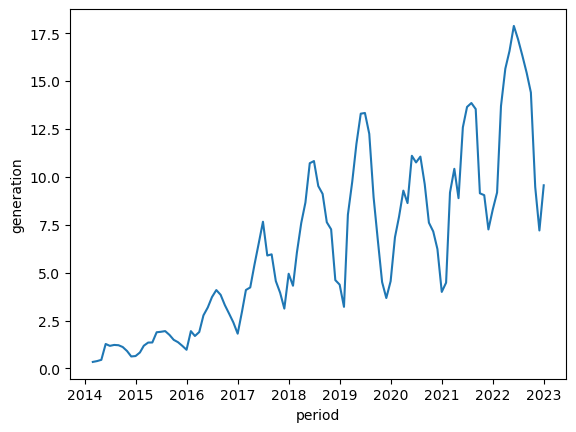

In [9]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [10]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -191.038
Date:                Mon, 10 Apr 2023   AIC                            394.076
Time:                        08:56:03   BIC                            410.113
Sample:                             0   HQIC                           400.577
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4249      2.181      2.945      0.003       2.150      10.700
ar.L1          1.3939      0.278      5.023      0.000       0.850       1.938
ar.L2         -0.4780      0.261     -1.829      0.0

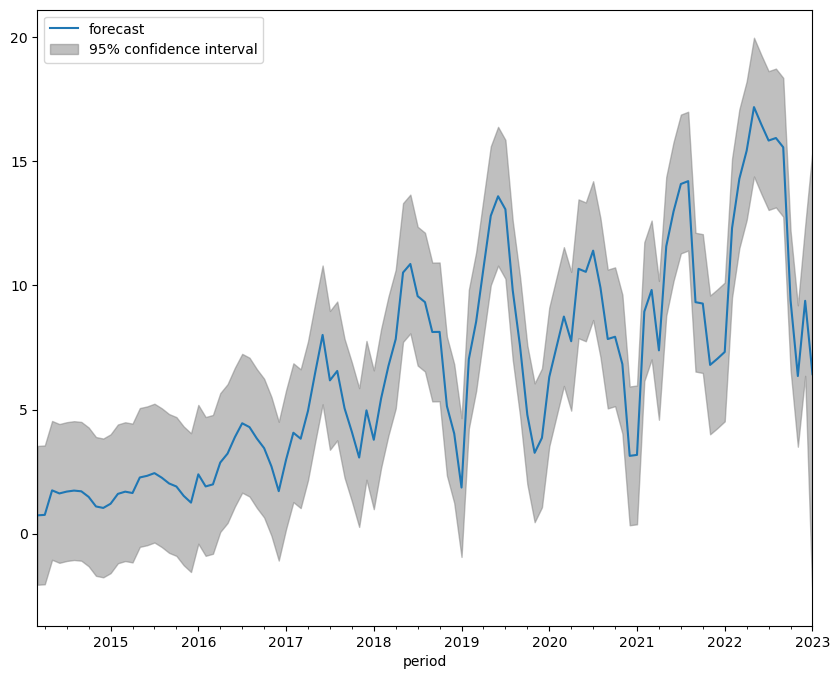

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")

In [13]:
sarimax = SARIMAX(y,order=(2,0,2),seasonal_order=(2,0,2,12)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -178.096
Date:                            Mon, 10 Apr 2023   AIC                            374.192
Time:                                    08:56:04   BIC                            398.247
Sample:                                         0   HQIC                           383.944
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2224      0.472      0.471      0.638      -0.703       1.148
ar.L2          0.6790      0.434      1.564      0.118      -0.172       1.530
ma.L1          0.7592      0.480      1.582      0.114      -0.182       1.700
ma.L2          0.0988      0.112      0.884      0.377      -0.120       0.318
ar.S.L12      -0.0374      4.508     -0.008      0.993      -8.874       8.799
ar.S.L24       0.8338      3.933      0.212      0.832      -6.875       8.543
ma.S.L12       0.4142      4.685      0.088      0.930      -8.768       9.596
ma.S.L24      -0.5070      2.260     -0.224      0.822      -4.936       3.922
sigma2         1.4756      0.273      5.402      0.000       0.940       2.011
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                12.46
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

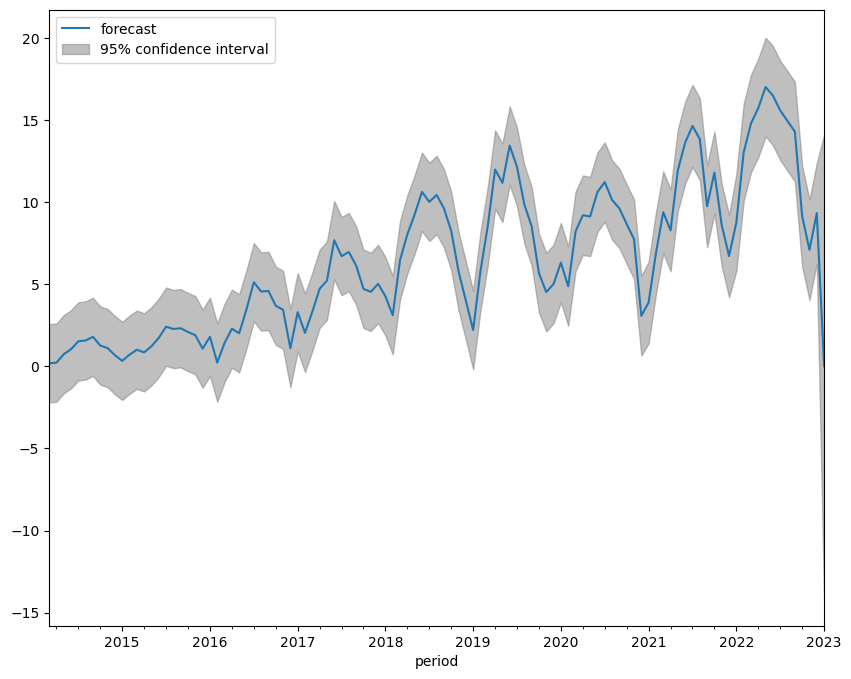

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(sarimax, ax=ax)
legend = ax.legend(loc="upper left")

In [16]:
try:
    (request := r.get(wind_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [17]:
json_data = request.json()

In [18]:
wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [19]:
wind_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01,MO,Missouri,99,All Sectors,WND,wind,664.16199,thousand megawatthours
1,2022-12,MO,Missouri,99,All Sectors,WND,wind,765.94774,thousand megawatthours
2,2022-11,MO,Missouri,99,All Sectors,WND,wind,794.67596,thousand megawatthours
3,2022-10,MO,Missouri,99,All Sectors,WND,wind,568.17608,thousand megawatthours
4,2022-09,MO,Missouri,99,All Sectors,WND,wind,468.58903,thousand megawatthours


In [20]:
wind_generation.period = pd.to_datetime(wind_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

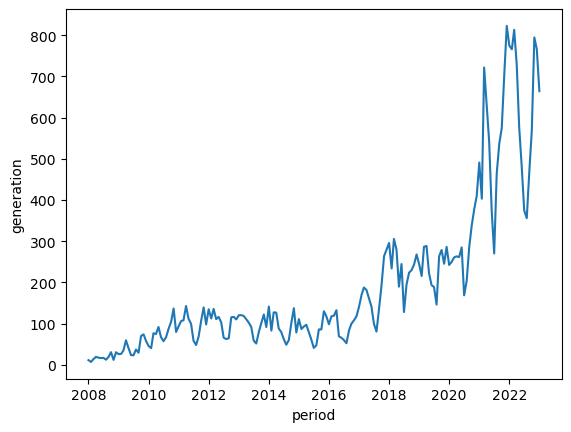

In [21]:
sns.lineplot(x="period",y="generation",data=wind_generation)

Hourly Prediction

In [22]:
solar_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MISO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=WND&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [23]:
try:
    (request := r.get(solar_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [24]:
json_data = request.json()

In [25]:
hourly_solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [26]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-10T05,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
1,2023-04-10T04,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
2,2023-04-10T03,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-04-10T02,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
4,2023-04-10T01,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,32,megawatthours


In [27]:
hourly_solar_generation.period = pd.to_datetime(hourly_solar_generation.period,utc=True)


In [28]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-10 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
1,2023-04-10 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
2,2023-04-10 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-04-10 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
4,2023-04-10 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,32,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

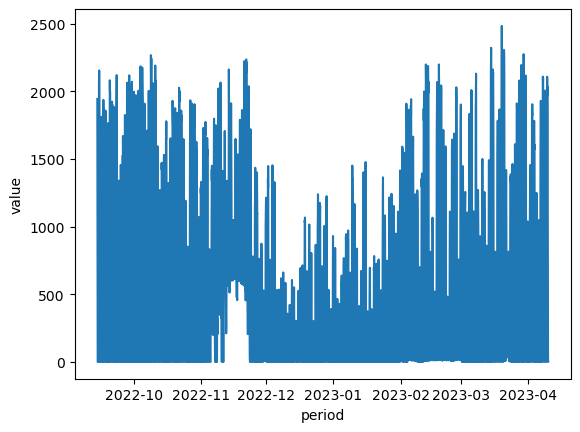

In [29]:
sns.lineplot(x="period",y="value",data=hourly_solar_generation)

In [30]:
try:
    (request := r.get(wind_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [31]:
json_data = request.json()

In [32]:
hourly_wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [33]:
hourly_wind_generation.period = pd.to_datetime(hourly_wind_generation.period,utc=True)

In [34]:
hourly_wind_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-10 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16144,megawatthours
1,2023-04-10 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,15535,megawatthours
2,2023-04-10 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,14578,megawatthours
3,2023-04-10 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,13422,megawatthours
4,2023-04-10 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,11759,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

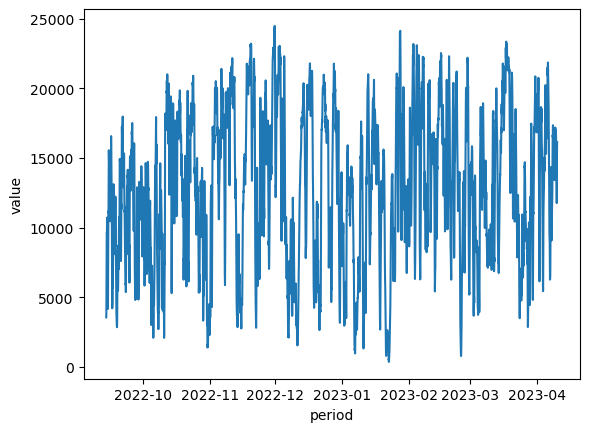

In [35]:
sns.lineplot(x="period",y="value",data=hourly_wind_generation)

Weather Data

In [57]:
hourly_forecast_data.startTime = pd.to_datetime(hourly_forecast_data.startTime).dt.round("H")

In [36]:
date = str(datetime.date.today())

hourly_weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude=38.63&longitude=-90.20&start_date=2022-06-01&end_date={date}&hourly=temperature_2m,cloudcover,windspeed_10m"

In [37]:
try:
    (request := r.get(hourly_weather_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [39]:
hourly_weather = pd.DataFrame(request.json().get("hourly"))

In [41]:
hourly_weather.time = pd.to_datetime(hourly_weather.time,utc=True)

Merge data sets

In [42]:
solar_weather = hourly_solar_generation.merge(hourly_weather,left_on="period" ,right_on="time",how="inner")

In [45]:
solar_weather.set_index("period", inplace=True)

In [46]:
solar_weather.head()

,respondent,respondent-name,fueltype,type-name,value,value-units,time,temperature_2m,cloudcover,windspeed_10m
period,,,,,,,,,,
2023-04-10 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours,2023-04-10 05:00:00+00:00,NaN,NaN,NaN
2023-04-10 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours,2023-04-10 04:00:00+00:00,NaN,NaN,NaN
2023-04-10 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-10 03:00:00+00:00,NaN,NaN,NaN
2023-04-10 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-10 02:00:00+00:00,NaN,NaN,NaN
2023-04-10 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,32,megawatthours,2023-04-10 01:00:00+00:00,NaN,NaN,NaN


In [47]:
columns_to_drop = ["respondent","respondent-name","fueltype","type-name","time","windspeed_10m","value-units"]
solar_weather.drop(columns_to_drop,axis=1,inplace=True)


In [48]:
solar_weather.dropna(inplace=True)

In [49]:
scaler = MinMaxScaler()
solar_weather = scaler.fit_transform(solar_weather)

In [50]:
n_future = 1
n_past = 24

train_X = []
train_y = []

for i in range(n_past, len(solar_weather) - n_future + 1):
    train_X.append(solar_weather[i - n_past:i, 0:solar_weather.shape[1]])
    train_y.append(solar_weather[i + n_future - 1:i + n_future, 0])
    


In [51]:
train_X, train_y = np.array(train_X),np.array(train_y)

In [52]:
model=Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

In [53]:
history = model.fit(train_X, train_y, epochs=50, batch_size=3,validation_split=0.1)

Epoch 1/50
1448/1448 [==============================] - 14s 8ms/step - loss: 0.0707 - val_loss: 0.0572
Epoch 2/50
1448/1448 [==============================] - 14s 10ms/step - loss: 0.0339 - val_loss: 0.0306
Epoch 3/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0293 - val_loss: 0.0475
Epoch 4/50
1448/1448 [==============================] - 20s 14ms/step - loss: 0.0268 - val_loss: 0.0274
Epoch 5/50
1448/1448 [==============================] - 20s 13ms/step - loss: 0.0256 - val_loss: 0.0321
Epoch 6/50
1448/1448 [==============================] - 21s 14ms/step - loss: 0.0246 - val_loss: 0.0325
Epoch 7/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0237 - val_loss: 0.0301
Epoch 8/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0228 - val_loss: 0.0251
Epoch 9/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0222 - val_loss: 0.0307
Epoch 10/50
1448/1448 [==============================] - 19s 13ms

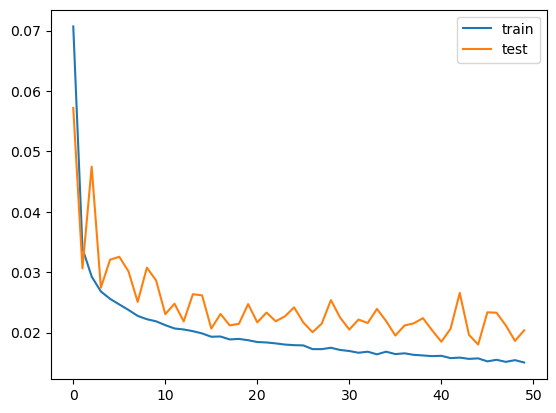

In [54]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [55]:
y_pred_train = model.predict(train_X)

151/151 [==============================] - 3s 7ms/step


In [56]:
pd.concat([pd.Series(train_y[:,0]),pd.Series(y_pred_train[:,0])],axis=1)

,0,1
0,0.533199,0.638818
1,0.640241,0.629087
2,0.746479,0.663981
3,0.767002,0.787456
4,0.733602,0.771203
...,...,...
4821,0.000000,-0.002901
4822,0.002414,-0.002542
4823,0.169014,0.052060
4824,0.567002,0.558866


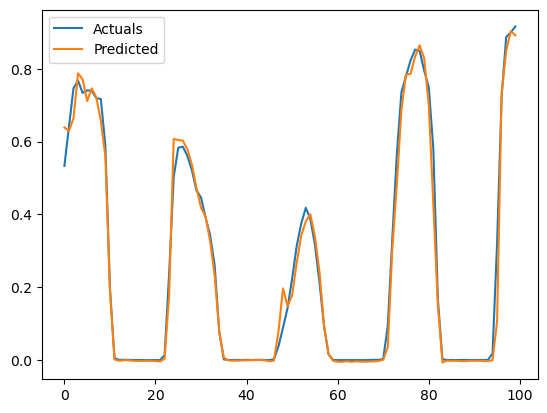

In [60]:
plt.plot(pd.Series(train_y[0:100,0]), label="Actuals")
plt.plot(pd.Series(y_pred_train[0:100,0]), label="Predicted")
plt.legend()
plt.show()